### U-net with simple Resnet Blocks v2, can get 0.80+
* Original version : 
  https://www.kaggle.com/shaojiaxin/u-net-with-simple-resnet-blocks
        
        
#### update log
1.   Cancel last dropout (seems better)
2.  modify convolution_block, to be more consistant with the standard resent model. 
      * https://arxiv.org/abs/1603.05027
3. Use faster  IOU metric score code,
      * https://www.kaggle.com/donchuk/fast-implementation-of-scoring-metric
4. Use  binary_crossentropy loss and then Lovász-hinge loss (very slow!)
     * Lovász-hinge loss: https://github.com/bermanmaxim/LovaszSoftmax
     
Limit the max epochs number to make the kernel finish in the limit of 6 hours, better score can be achived at more epochs 

In [1]:
import os, sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from func import img_process
from func import custom_loss

import random
import pydot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers
from keras.applications.resnet50 import ResNet50
from keras.utils.vis_utils import plot_model
from keras.backend import tensorflow_backend, common
from keras.backend.tensorflow_backend import set_session

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

os.environ["CUDA_VISIBLE_DEVICES"]="1"

import time
t_start = time.time()

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
version = 5
basic_name = f'Unet_resnet_v{version}'
save_model_name = basic_name + 'nearest.model'
submission_file = basic_name + '.csv'

print(save_model_name)
print(submission_file)

Unet_resnet_v5nearest.model
Unet_resnet_v5.csv


In [3]:
# keep split same
if(os.path.isfile('val_df.csv') is False):
    train_df, val_df, test_df = img_process.create_train_val_test_split_df()
    train_df.to_csv('./train_df.csv')
    val_df.to_csv('./val_df.csv')
    test_df.to_csv('./test_df.csv')
else:
    train_df = pd.read_csv("./train_df.csv")
    val_df = pd.read_csv("./val_df.csv")
    test_df = pd.read_csv("./test_df.csv")

In [4]:
x_train = img_process.read_train_img_to_np_array(train_df)
y_train = img_process.read_mask_img_to_np_array(train_df)
x_valid = img_process.read_train_img_to_np_array(val_df)
y_valid = img_process.read_mask_img_to_np_array(val_df)

In [5]:
#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(6400, 128, 128, 3)
(6400, 128, 128, 1)
(800, 128, 128, 3)
(800, 128, 128, 1)


In [6]:
# tensorflow session setting
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
set_session(tf.Session(config=tf_config))

In [7]:
from segmentation_models import Unet

# prepare model
model1 = Unet(backbone_name='inceptionresnetv2', encoder_weights='imagenet')
c = optimizers.adam(0.001)
model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[custom_loss.my_iou_metric])

# model1.summary()
# SVG(model_to_dot(model1, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [ ]:
#early_stopping = EarlyStopping(monitor='my_iou_metric', mode = 'max',patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)

epochs = 50
batch_size = 16
history = model1.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint,reduce_lr], 
                    verbose=2)

Train on 6400 samples, validate on 800 samples
Epoch 1/50
 - 191s - loss: 0.3520 - my_iou_metric: 0.2395 - val_loss: 2.9184 - val_my_iou_metric: 0.3570

Epoch 00001: my_iou_metric improved from -inf to 0.23947, saving model to Unet_resnet_v5nearest.model
Epoch 2/50
 - 151s - loss: 0.2129 - my_iou_metric: 0.6029 - val_loss: 0.1920 - val_my_iou_metric: 0.6630

Epoch 00002: my_iou_metric improved from 0.23947 to 0.60289, saving model to Unet_resnet_v5nearest.model
Epoch 3/50
 - 148s - loss: 0.1974 - my_iou_metric: 0.6558 - val_loss: 0.2060 - val_my_iou_metric: 0.6904

Epoch 00003: my_iou_metric improved from 0.60289 to 0.65578, saving model to Unet_resnet_v5nearest.model
Epoch 4/50
 - 150s - loss: 0.1715 - my_iou_metric: 0.6935 - val_loss: 0.1712 - val_my_iou_metric: 0.7251

Epoch 00004: my_iou_metric improved from 0.65578 to 0.69345, saving model to Unet_resnet_v5nearest.model
Epoch 5/50


In [10]:
model1 = load_model(save_model_name,custom_objects={'my_iou_metric': custom_loss.my_iou_metric})
# model1 = load_model(save_model_name,custom_objects={'my_iou_metric': my_iou_metric, 'lovasz_loss': lovasz_loss, 'my_iou_metric_2': my_iou_metric_2})
# remove layter activation layer and use losvasz loss
input_x = model1.layers[0].input

output_layer = model1.layers[-1].input
model = Model(input_x, output_layer)
c = optimizers.adam(0.0005)

# lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
# Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
model.compile(loss=custom_loss.lovasz_loss, optimizer=c, metrics=[custom_loss.my_iou_metric_2])

#model.summary()

In [ ]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=20, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=5, min_lr=0.00001, verbose=1)
epochs = 100
batch_size = 16

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint,reduce_lr,early_stopping], 
                    verbose=2)

Train on 6400 samples, validate on 800 samples
Epoch 1/100
 - 289s - loss: 0.2520 - my_iou_metric_2: 0.8728 - val_loss: 0.4801 - val_my_iou_metric_2: 0.7768

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.77675, saving model to Unet_resnet_v5nearest.model
Epoch 2/100
 - 239s - loss: 0.2343 - my_iou_metric_2: 0.8742 - val_loss: 0.4421 - val_my_iou_metric_2: 0.7855

Epoch 00002: val_my_iou_metric_2 improved from 0.77675 to 0.78550, saving model to Unet_resnet_v5nearest.model
Epoch 3/100
 - 239s - loss: 0.2383 - my_iou_metric_2: 0.8704 - val_loss: 0.6520 - val_my_iou_metric_2: 0.6900

Epoch 00003: val_my_iou_metric_2 did not improve from 0.78550
Epoch 4/100
 - 238s - loss: 0.2943 - my_iou_metric_2: 0.8354 - val_loss: 0.4629 - val_my_iou_metric_2: 0.7577

Epoch 00004: val_my_iou_metric_2 did not improve from 0.78550
Epoch 5/100
 - 235s - loss: 0.2364 - my_iou_metric_2: 0.8625 - val_loss: 0.4308 - val_my_iou_metric_2: 0.7785

Epoch 00005: val_my_iou_metric_2 did not improve from 0

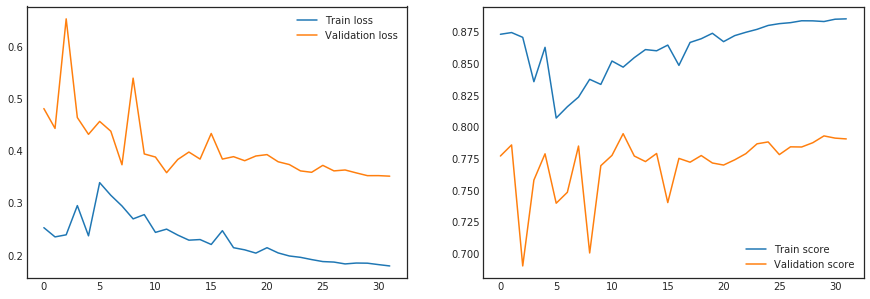

In [13]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()

In [9]:
model = load_model(save_model_name,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

In [10]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [26]:
preds_valid = predict_result(model,x_valid,128)

In [27]:
#Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
#     temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)



In [43]:
y_valid_pad = y_valid[:,14:-13, 14:-13,:]
preds_valid_pad = preds_valid[:,14:-13, 14:-13]

In [41]:
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid_pad, preds_valid_pad > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)

[ 0.81375   0.814875  0.817     0.817375  0.818625  0.819125  0.81975
  0.821125  0.821125  0.823     0.822875  0.821875  0.821375  0.821375
  0.821125  0.82225   0.820125  0.818625  0.819125  0.817625  0.817125
  0.8165    0.81575   0.814875  0.814375  0.813375  0.81275   0.812625
  0.811     0.80925   0.808   ]


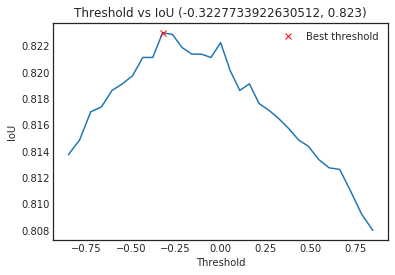

In [42]:
# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [11]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [16]:
x_test = np.array([uppad((np.array(load_img("../data/test/{}.png".format(idx), grayscale = True))) / 255) for idx in tqdm_notebook(test_df.index)])
x_test_stack = np.stack((x_test,)*3,-1)

In [17]:
x_test_stack.shape

(18000, 128, 128, 3)

In [18]:
preds_test = predict_result(model,x_test_stack,128)

In [21]:
preds_test = preds_test[:,14:-13, 14:-13]

In [23]:
threshold_best = 0.32277339
t1 = time.time()
pred_dict = {idx: rle_encode(np.round(preds_test[i] > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

Usedtime = 8.119457006454468 s


In [24]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submission_file)

In [ ]:
t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")